In [49]:
import os
from pathlib import Path
from typing import List, Optional
from collections import defaultdict


import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt


# Hack the system path a little bit so we can import ..scripts.utils
import sys
sys.path.append('..')

from scripts import utils

In [42]:
OUTPUT_DIR = Path("../output")
DATA_DIR = Path("../data")

# Helper functions

In [28]:
# Path functions
def get_subdirs(d: Path) -> List[Path]:
    return [f for f in d.iterdir() if f.is_dir()]

def get_exp_paths(exp_name: str, *, most_recent=False) -> List[Path]:
    paths = DATA_DIR.glob(f"*{exp_name}*")
    paths = sorted(paths, key=os.path.getmtime, reverse=True)
    if most_recent:
        return [paths[0]]
    return paths

In [5]:
# Log functions

# https://github.com/franklinfrank/285project/blob/diff_ac/cs285/infrastructure/rl_trainer.py#L278-L301
def parse_tf_eventsfile(filename: str, *, tag='Eval_AverageReturn') -> List:
    eval_returns = []
    for e in tf.train.summary_iterator(filename):
        for v in e.summary.value:
            if v.tag == tag:
                eval_returns.append(v.simple_value)

    return eval_returns

# Plotting Code

In [131]:
DEFAULT_FIGSIZE = (12,10)

FREE_VARIABLES = {
    'env_sweep': 'env', 
    'sample_sweep': 'sample_strategy',
    'terminal_val_sweep': 'terminal_val',
    'batch_size_sweep': 'batch_size'
}

def plot_exp_set(exp_set_name: str) -> None:
    """ Always averages over seeds
    """ 
    
    # Create a figure for each environment
    (plt.figure(figsize=DEFAULT_FIGSIZE) for _ in utils.environments)
    
    logfiles = defaultdict(lambda: defaultdict(list))
    for exp_flags in (utils.get_exp_flags(exp_set_name)):
        # Get the run_folder for this combination of experiment flags
        exp_name = utils.get_exp_name(exp_flags)
        run_folder = get_exp_paths(exp_name, most_recent=True)[0]
        # Identify the logfile
        logfile = str(list(run_folder.iterdir())[0])
        
        # Average over seed, so get a exp_name that excludes the seed
        exp_flags.pop('seed')
        exp_label = utils.get_exp_name(exp_flags)
        logfiles[exp_flags['env_name']][exp_label].append(logfile)
    
    ys_to_plot = []
    # Average over seed
    for env_name, trials in logfiles.items():
        for label, files in trials.items():
            trial_ys = []
            for logfile in files:
                trial_ys.append(parse_tf_eventsfile(logfile))
            trial_ys = np.array(trial_ys)
            
            y_min = np.min(trial_ys, axis=0)
            y_avg = np.average(trial_ys, axis=0)
            y_max = np.max(trial_ys, axis=0)
            xs = range(y_avg.shape[0])
            
            # Get the correct figure
            plt.figure(utils.environments.index(env_name))
            plt.plot(y_avg, label=label)
            plt.fill_between(xs, y_min, y_max, alpha=.2)
            plt.legend()
    
    plt.show()

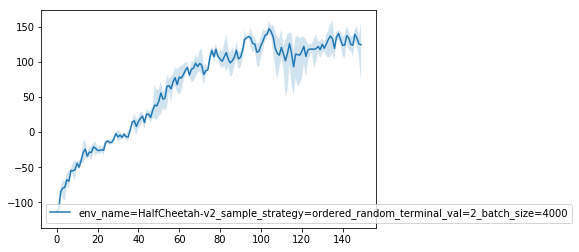

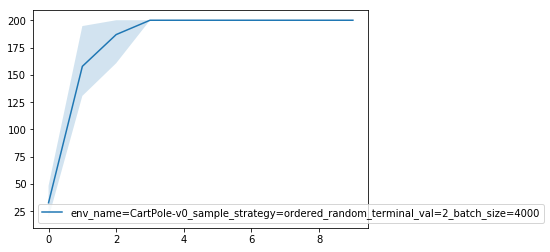

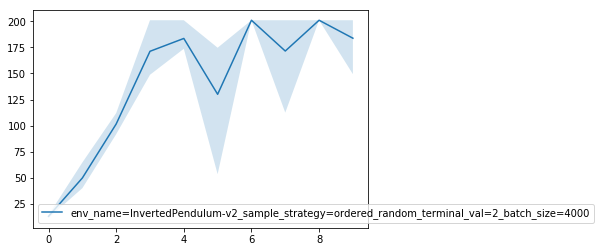

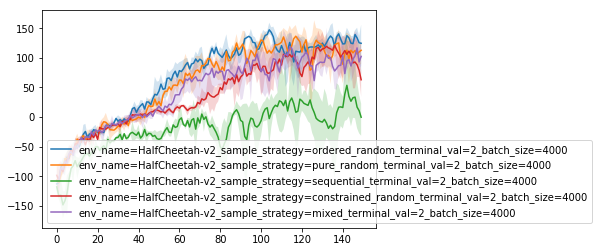

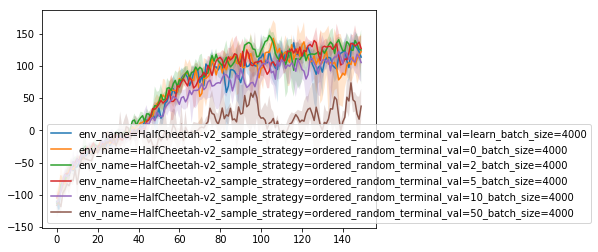

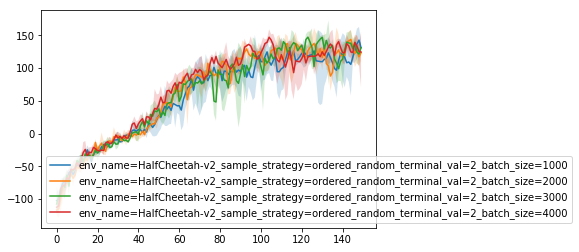

In [130]:
plot_exp_set('env_sweep')
plot_exp_set('sample_sweep')
plot_exp_set('terminal_val_sweep')
plot_exp_set('batch_size_sweep')